#### CSML1020 Course Project - New Plant Diseases Dectection
#### Authors (Group 3): Paul Doucet, Jerry Khidaroo

#### Initilization

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import os

In [2]:
# adjust pandas display
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.precision = 2
pd.options.display.max_colwidth = -1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [3]:
# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

In [4]:
import tensorflow as tf


In [5]:
# Use this to enable GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for physical_device in physical_devices:
    tf.config.experimental.set_memory_growth(physical_device, True)

In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
# # Use this to disable GPU
# tf.config.set_visible_devices([], 'GPU')

In [8]:
from keras.applications.vgg16 import VGG16
import keras
from sklearn.model_selection import train_test_split
from keras import backend
from keras.layers import Dense
from keras.layers import Flatten
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.optimizers import SGD
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


#### Model and Benchmarking Function Definitions

In [9]:
# Importing Keras libraries and packages
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
from keras import optimizers

def get_alexnet_model(learning_rate):
    # Initializing the CNN
    classifier = Sequential()

    # Convolution Step 1
    classifier.add(Convolution2D(96, 11, strides = (4, 4), padding = 'valid', input_shape=(224, 224, 3), activation = 'relu'))

    # Max Pooling Step 1
    classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
    classifier.add(BatchNormalization())

    # Convolution Step 2
    classifier.add(Convolution2D(256, 11, strides = (1, 1), padding='valid', activation = 'relu'))

    # Max Pooling Step 2
    classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding='valid'))
    classifier.add(BatchNormalization())

    # Convolution Step 3
    classifier.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
    classifier.add(BatchNormalization())

    # Convolution Step 4
    classifier.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
    classifier.add(BatchNormalization())

    # Convolution Step 5
    classifier.add(Convolution2D(256, 3, strides=(1,1), padding='valid', activation = 'relu'))

    # Max Pooling Step 3
    classifier.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
    classifier.add(BatchNormalization())

    # Flattening Step
    classifier.add(Flatten())

    # Full Connection Step
    classifier.add(Dense(units = 4096, activation = 'relu'))
    classifier.add(Dropout(0.4))
    classifier.add(BatchNormalization())
    classifier.add(Dense(units = 4096, activation = 'relu'))
    classifier.add(Dropout(0.4))
    classifier.add(BatchNormalization())
    classifier.add(Dense(units = 1000, activation = 'relu'))
    classifier.add(Dropout(0.2))
    classifier.add(BatchNormalization())
    classifier.add(Dense(units = 38, activation = 'softmax'))

    classifier.load_weights('/home/jupyter/input/plant-diseases-classification-using-alexnet/best_weights_9.hdf5')
    #classifier.load_weights('../input/bestweights9/best_weights_9.hdf5')

    # we chose to train the top 2 conv blocks, i.e. we will freeze
    # the first 8 layers and unfreeze the rest:
    for i, layer in enumerate(classifier.layers[:20]):
        layer.trainable = False

    # Compiling the Model
    classifier.compile(optimizer=optimizers.SGD(lr=learning_rate, momentum=0.9, decay=0.005), loss='categorical_crossentropy', metrics=['accuracy'])
   
    return classifier

In [10]:
def get_model(base_model):
    #base_model=VGG16(include_top=False,input_shape=(224,224,3))
    base_model.trainable=False

    classifier=keras.models.Sequential()
    classifier.add(base_model)
    classifier.add(Flatten())
    
    classifier.add(Dense(38,activation='softmax'))
    
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return classifier

In [11]:
def get_model_A():
    classifier = Sequential()
    classifier.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(224, 224, 3)))
    classifier.add(MaxPooling2D((2, 2)))
    #classifier.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    #classifier.add(MaxPooling2D((2, 2)))
    #classifier.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    #classifier.add(MaxPooling2D((2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    classifier.add(Dense(38,activation='softmax'))
    
    #opt = SGD(lr=0.001, momentum=0.9)
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return classifier

In [12]:
def get_model_B():
    classifier = Sequential()
    classifier.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(224, 224, 3)))
    classifier.add(MaxPooling2D((2, 2)))
    classifier.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    classifier.add(MaxPooling2D((2, 2)))
    #classifier.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    #classifier.add(MaxPooling2D((2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    classifier.add(Dense(38,activation='softmax'))
    
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return classifier

In [13]:
def get_model_C():
    classifier = Sequential()
    classifier.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(224, 224, 3)))
    classifier.add(MaxPooling2D((2, 2)))
    classifier.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    classifier.add(MaxPooling2D((2, 2)))
    classifier.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    classifier.add(MaxPooling2D((2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    classifier.add(Dense(38,activation='softmax'))
    
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return classifier

In [14]:
def get_model_D():
    classifier = Sequential()
    classifier.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(224, 224, 3)))
    classifier.add(MaxPooling2D((2, 2)))
    classifier.add(Dropout(0.2))
    classifier.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    classifier.add(MaxPooling2D((2, 2)))
    classifier.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    classifier.add(MaxPooling2D((2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    classifier.add(Dense(38,activation='softmax'))
    
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return classifier

In [15]:
def Save_Benchmark(descr, metric, reset_rb, init_rb):
    global rows_benchmarks
    global df_benchmarks
    if (init_rb):
        rows_benchmarks = []
    else:
        if (reset_rb):
            rows_benchmarks = []

        rows_benchmarks.append([descr, metric])
        df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Pre-Prosessing Steps", "Validation Accuracy"])

In [16]:
def Save_Model_Benchmark(descr, history, reset_rb, init_rb):
    global rows_model_benchmarks
    global df_model_benchmarks
    if (init_rb):
        rows_model_benchmarks = []
    else:
        if (reset_rb):
            rows_model_benchmarks = []

        rows_model_benchmarks.append([descr, history.history['accuracy'][-1], history.history['loss'][-1], history.history['val_accuracy'][-1], 
            history.history['val_loss'][-1],])
        df_model_benchmarks = pd.DataFrame(rows_model_benchmarks, columns=["Classifier", "Accuracy", "Loss", "Validation Accuracy", "Validation Loss"])

In [17]:
def run_model(train_datagen, valid_set, batch_size, epochs):    
    training_set = train_datagen.flow_from_directory(dataDirTrain, target_size=(224, 224), batch_size=batch_size, class_mode='categorical')

    train_num = training_set.samples
    valid_num = valid_set.samples

    base_model=VGG16(include_top=False,input_shape=(224,224,3))
    classifier = get_model(base_model)
    
    #fitting images to CNN
    history = classifier.fit(training_set, steps_per_epoch=train_num//batch_size, validation_data=valid_set, epochs=epochs, validation_steps=valid_num//batch_size)

    return history

In [18]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set()

def plot_history(model, history, axs, row):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    #accuracy plot   
    axs[row, 0].plot(epochs, acc, color='green', label='Training Accuracy')
    axs[row, 0].plot(epochs, val_acc, color='blue', label='Validation Accuracy')
    axs[row, 0].set_title(model + ' Training and Validation Accuracy')
    axs[row, 0].set_xlabel('Epoch')
    axs[row, 0].set_ylabel('Accuracy')
    axs[row, 0].legend()
    
    #loss plot   
    axs[row, 1].plot(epochs, loss, color='pink', label='Training Loss')
    axs[row, 1].plot(epochs, val_loss, color='red', label='Validation Loss')
    axs[row, 1].set_title(model + ' Training and Validation Loss')
    axs[row, 1].set_xlabel('Epoch')
    axs[row, 1].set_ylabel('Accuracy')
    axs[row, 1].legend()

#### Data Importing

In [19]:
import os
os.listdir('/home/jupyter/input/plant-diseases-classification-using-alexnet')

['AlexNetModel.hdf5', 'best_weights_9.hdf5']

In [21]:
# Image Data Folders
# dataDirTrain = '../NewPlantDiseasesDatasetSample/train'
# dataDirValidate = '../NewPlantDiseasesDatasetSample/valid'
# dataDirTest = '../NewPlantDiseasesDatasetSample/test'

#dataDirTrain = '../NewPlantDiseasesDataset/train'
#dataDirValidate = '../NewPlantDiseasesDataset/valid'
#dataDirTest = '../NewPlantDiseasesDataset/test'

# From Kaggle Site
#dataDirTrain = '../input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train'
#dataDirValidate = '../input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid'
#dataDirTest = '../input/newplantdiseasessample/NewPlantDiseasesDatasetSample/test'

# GCP
#/home/jupyter/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)
dataDirTrain = '/home/jupyter/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train'
dataDirValidate = '/home/jupyter/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid'
dataDirTest = '/home/jupyter/test/test'

#### Data Pre-Processing Benchmarks

In [ ]:
dg_descrs = ["rescale=1./255", 
    "rescale=1./255, shear_range=0.2", 
    #"rescale=1./255, zoom_range=0.2", 
    #"rescale=1./255, shear_range=0.2, zoom_range=0.2",
    #"rescale=1./255, shear_range=0.2, zoom_range=0.2, brightness_range=[0.2,1.0]",
    # "rescale=1./255, shear_range=0.2, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2",
    # "rescale=1./255, horizontal_flip=True, vertical_flip=True, rotation_range=90, brightness_range=[0.2,1.0], zoom_range=[0.5,1.0]"
]

datagens = [
    ImageDataGenerator(rescale=1./255, fill_mode='nearest'),
    ImageDataGenerator(rescale=1./255, shear_range=0.2, fill_mode='nearest'),
    #ImageDataGenerator(rescale=1./255, zoom_range=0.2, fill_mode='nearest'),
    #ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, fill_mode='nearest'),
    #ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, brightness_range=[0.2,1.0], fill_mode='nearest'),
    #ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='nearest'),
    #ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True, rotation_range=90, brightness_range=[0.2,1.0], zoom_range=[0.5,1.0], fill_mode='nearest'),
]

batch_size = 48
epochs = 3
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_set = valid_datagen.flow_from_directory(dataDirValidate, target_size=(224, 224), batch_size=batch_size, class_mode='categorical')
Save_Benchmark("", "", False, True)

for train_datagen, dg_descr in zip(datagens, dg_descrs):
    history = run_model(train_datagen, valid_set, batch_size, epochs)
    Save_Benchmark(dg_descr, history.history['val_accuracy'][2], False, False)
    
df_benchmarks

#### Load Train Image Data with Best Augmentation Filters

In [22]:
# train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='nearest')
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1./255)

# batch_size = 128
batch_size = 64
training_set = train_datagen.flow_from_directory(dataDirTrain, target_size=(224, 224), batch_size=batch_size, class_mode='categorical')
valid_set = valid_datagen.flow_from_directory(dataDirValidate, target_size=(224, 224), batch_size=batch_size, class_mode='categorical')

train_num = training_set.samples
valid_num = valid_set.samples

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [22]:
# class_dict = training_set.class_indices
# print(class_dict)

In [23]:
# li = list(class_dict.keys())
# print(li)

#### Baseline Models From Scratch

In [ ]:
# Initialize Models
Base_model_ids = ['Model_A', 'Model_B', 'Model_C', 'Model_D']
Base_models = [
    get_model_A(),
    get_model_B(),
    get_model_C(),
    get_model_D(),
]

#### Train Base Models

In [ ]:
from keras.callbacks import ModelCheckpoint

epochs = 3

# Initialize function
Save_Model_Benchmark("", "", False, True)

# Train Models and Save Histories
histories = []
for classifier, model_id in zip(Base_models, Base_model_ids):
    history = classifier.fit(training_set, steps_per_epoch=train_num//batch_size, validation_data=valid_set, epochs=epochs, validation_steps=valid_num//batch_size, )
    Save_Model_Benchmark(model_id, history, False, False)
    histories.append(history)

df_model_benchmarks

#### Plot Base Models

In [ ]:
import matplotlib.gridspec as gridspec
import itertools

# Plot Accuacy and Loss for Model Histories
fig, axs = plt.subplots(5, 2, figsize=(12,18))

row = 0
for history, model_id in zip(histories, Base_model_ids): 
    plot_history(model_id, history, axs, row)
    row = row + 1

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.3, wspace=0.25)
plt.show()

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


# Print Model Layers
for classifier, model_id in zip(Base_models, Base_model_ids):
    print('Visualization of Layers for: ', model_id, ' base Model with Transfer Learning')
    print('')
    display(SVG(model_to_dot(classifier, show_shapes=True, show_layer_names=False, dpi=70, rankdir='TB').create(prog='dot', format='svg')))
    print('')

#### Define Models to Investigate

In [ ]:
from keras.applications import InceptionV3
from keras.applications.resnet50 import ResNet50

# Initialize Models
model_ids = ['VGG16', 'ResNet50', 'InceptionV3', 'Alexnet', 'Model_01']
models = [
    get_model(VGG16(include_top=False,input_shape=(224,224,3))),
    get_model(ResNet50(include_top=False,input_shape=(224,224,3))),
    get_model(InceptionV3(include_top=False,input_shape=(224,224,3))),
    get_alexnet_model(),
    get_model_01(),
]

# model_ids = ['Model_01']
# models = [
#     get_model_01(),
# ]

#### Visualize Model Layers

In [ ]:
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# # Print Model Layers
# for classifier, model_id in zip(models, model_ids):
#     print('Visualization of Layers for: ', model_id, ' base Model with Transfer Learning')
#     print('')
#     display(SVG(model_to_dot(classifier, show_shapes=True, show_layer_names=False, dpi=70, rankdir='TB').create(prog='dot', format='svg')))
#     print('')

#### Train Models

In [ ]:
from keras.callbacks import ModelCheckpoint

# checkpoint for Alexnet Model
weightpath = "best_weights_9.hdf5"
checkpoint = ModelCheckpoint(weightpath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
callbacks_list = [checkpoint]# checkpoint
epochs = 3

# Initialize function
Save_Model_Benchmark("", "", False, True)

# Train Models and Save Histories
histories = []
for classifier, model_id in zip(models, model_ids):
    if model_id == 'Alexnet':
        history = classifier.fit(training_set, steps_per_epoch=train_num//batch_size, validation_data=valid_set, epochs=epochs, validation_steps=valid_num//batch_size, callbacks=callbacks_list, )  
    else:
          history = classifier.fit(training_set, steps_per_epoch=train_num//batch_size, validation_data=valid_set, epochs=epochs, validation_steps=valid_num//batch_size, )
    Save_Model_Benchmark(model_id, history, False, False)
    histories.append(history)

df_model_benchmarks

#### Plot Model Training Results

In [ ]:
import matplotlib.gridspec as gridspec
import itertools

# Plot Accuacy and Loss for Model Histories
fig, axs = plt.subplots(5, 2, figsize=(12,18))

row = 0
for history, model_id in zip(histories, model_ids): 
    plot_history(model_id, history, axs, row)
    row = row + 1

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.3, wspace=0.25)
plt.show()

In [ ]:
#fitting images to CNN
# history = classifier.fit(training_set,
#                          steps_per_epoch=train_num//batch_size,
#                          validation_data=valid_set,
#                          epochs=3,
#                          validation_steps=valid_num//batch_size,
#                          )

#### Perform Hyper-Parameter Tuning on Selected Model (Done in Plant_Disease_Detection_Augm_hp_tuning.ipynb due to errors in GPU mode.)

#### Re-Run Selected Model with Tuned Hyper-Parameters

In [23]:
def get_VGG16_Tuned(base_model, learning_rate):
    #base_model=VGG16(include_top=False,input_shape=(224,224,3))
    base_model.trainable=False

    classifier=keras.models.Sequential()
    classifier.add(base_model)
    classifier.add(Flatten())
    
    classifier.add(Dense(38,activation='softmax'))
    
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    classifier.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return classifier

In [24]:
def get_model_D_Tuned(learning_rate):
    classifier = Sequential()
    classifier.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(224, 224, 3)))
    classifier.add(MaxPooling2D((2, 2)))
    classifier.add(Dropout(0.2))
    classifier.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    classifier.add(MaxPooling2D((2, 2)))
    classifier.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    classifier.add(MaxPooling2D((2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    classifier.add(Dense(38,activation='softmax'))
    
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    classifier.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return classifier

In [25]:
def Save_Model(model, model_id):
    filepath="./" + model_id + ".h5"
    classifier.save(filepath)

In [26]:
# Initialize Models
#model_ids_tuned = ['Alexnet_Tuned', 'VGG16_Tuned', 'Model_D_Tuned']
model_ids_tuned = ['VGG16_Tuned', 'Model_D_Tuned']
models_tuned = [
    #get_alexnet_model(0.01),
    get_VGG16_Tuned(VGG16(include_top=False,input_shape=(224,224,3)),0.001),
    get_model_D_Tuned(0.001),
]

In [27]:
from keras.callbacks import ModelCheckpoint

# checkpoint for Alexnet Model
#weightpath = "/home/jupyter/input/plant-diseases-classification-using-alexnet/best_weights_9.hdf5"
#checkpoint = ModelCheckpoint(weightpath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
#callbacks_list = [checkpoint]# checkpoint
#callbacks_list = [checkpoint]

batch_sizes = [64, 48]
epochs = [5, 5]

# Initialize function
Save_Model_Benchmark("", "", False, True)

# Train Models and Save Histories
histories = []
for classifier, model_id, batch_size, epoch in zip(models_tuned, model_ids_tuned, batch_sizes, epochs):
    
    #if model_id == 'Alexnet_Tuned':
    #    history = classifier.fit(training_set, steps_per_epoch=train_num//batch_size, validation_data=valid_set, epochs=epoch, validation_steps=valid_num//batch_size, callbacks=callbacks_list)  
    #else:
    history = classifier.fit(training_set, steps_per_epoch=train_num//batch_size, validation_data=valid_set, epochs=epoch, validation_steps=valid_num//batch_size)
    Save_Model_Benchmark(model_id, history, False, False)
    Save_Model(classifier, model_id)
    histories.append(history)

df_model_benchmarks

Epoch 1/10
2196/2196 [==============================] - 2749s 1s/step - loss: 0.2832 - accuracy: 0.9127 - val_loss: 0.1041 - val_accuracy: 0.9217
Epoch 2/10
2196/2196 [==============================] - 1801s 820ms/step - loss: 0.0941 - accuracy: 0.9695 - val_loss: 0.1493 - val_accuracy: 0.9453
Epoch 3/10
2196/2196 [==============================] - 1787s 814ms/step - loss: 0.0733 - accuracy: 0.9773 - val_loss: 0.0908 - val_accuracy: 0.9484
Epoch 4/10
2196/2196 [==============================] - 1784s 812ms/step - loss: 0.0567 - accuracy: 0.9833 - val_loss: 0.5382 - val_accuracy: 0.9445
Epoch 5/10
2196/2196 [==============================] - 1784s 813ms/step - loss: 0.0436 - accuracy: 0.9874 - val_loss: 0.0825 - val_accuracy: 0.9532
Epoch 6/10
2196/2196 [==============================] - 1786s 813ms/step - loss: 0.0414 - accuracy: 0.9884 - val_loss: 0.9483 - val_accuracy: 0.8940
Epoch 7/10
2196/2196 [==============================] - 1782s 811ms/step - loss: 0.0356 - accuracy: 0.9902 - 

,Classifier,Accuracy,Loss,Validation Accuracy,Validation Loss
0,VGG16_Tuned,0.99,0.03,0.95,0.59
1,Model_D_Tuned,0.77,0.75,0.65,1.07


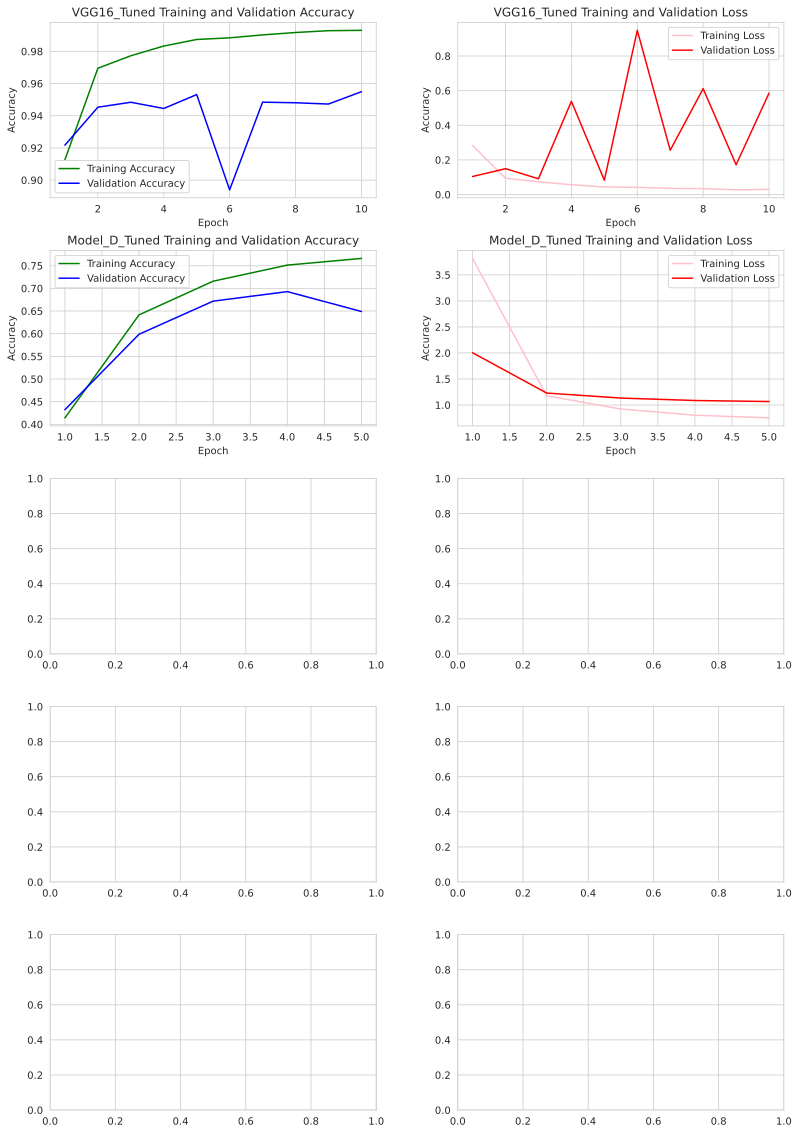

In [28]:
import matplotlib.gridspec as gridspec
import itertools

# Plot Accuacy and Loss for Model Histories
fig, axs = plt.subplots(5, 2, figsize=(12,18))

row = 0
for history, model_id in zip(histories, model_ids_tuned): 
    plot_history(model_id, history, axs, row)
    row = row + 1

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.3, wspace=0.25)
plt.show()

In [ ]:
# Save Final Model
filepath="./Mymodel_sample.h5"
classifier.save(filepath)A

#### Inference

In [ ]:
# predicting an image
from keras.preprocessing import image
import numpy as np
image_path = "../NewPlantDiseasesDataset/test/Tomato_Late_blight01.JPG"
new_img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

print("Following is our prediction:")
prediction = classifier.predict(img)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
d = prediction.flatten()
j = d.max()
for index,item in enumerate(d):
    if item == j:
        class_name = li[index]

#ploting image with predicted class name        
plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.title(class_name)
plt.show()